# Part 1: GAN

## Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.



In [48]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
                              train=True,
                              download=True,
                              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [49]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [50]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


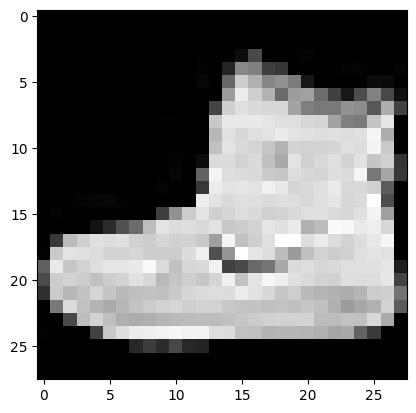

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [52]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([9, 6, 3, 4, 0, 7, 5, 3, 3, 2, 7, 6, 2, 5, 2, 7, 4, 7, 8, 5, 8, 3, 4, 3,
        6, 5, 5, 9, 8, 0, 7, 5, 2, 6, 2, 4, 4, 9, 8, 4, 5, 5, 3, 2, 5, 8, 3, 5,
        5, 5, 8, 1, 8, 7, 3, 0, 2, 7, 7, 9, 5, 4, 4, 7, 6, 6, 9, 7, 0, 3, 8, 8,
        6, 9, 4, 4, 4, 7, 3, 4, 0, 3, 9, 3, 1, 5, 3, 4, 6, 1, 5, 3, 6, 4, 8, 2,
        7, 0, 2, 1])


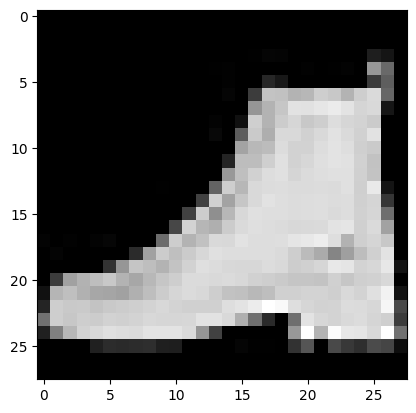

In [53]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [54]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [55]:
device

device(type='cuda')

## Discriminator Network

In [56]:
image_size = 784
hidden_size = 256

In [57]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [58]:
D.to(device);

## Generator Network

In [59]:
latent_size = 64

In [60]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [61]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

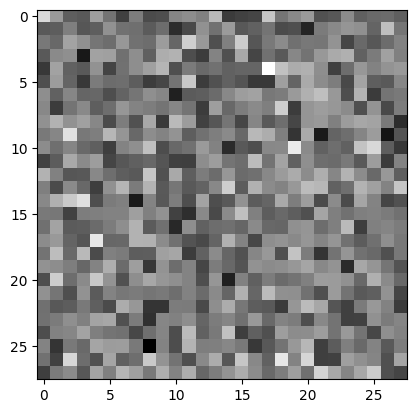

In [62]:
plt.imshow(gen_imgs[0], cmap='gray');

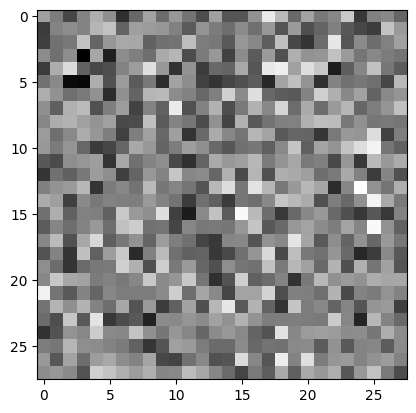

In [63]:
plt.imshow(gen_imgs[1], cmap='gray');

In [64]:
G.to(device);

## Discriminator Training


In [65]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [66]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

## Generator Training

In [67]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [68]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## Training the Model


In [69]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

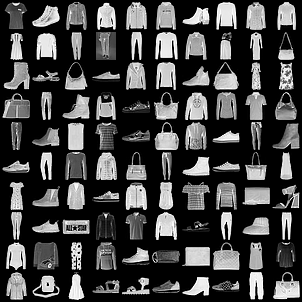

In [70]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


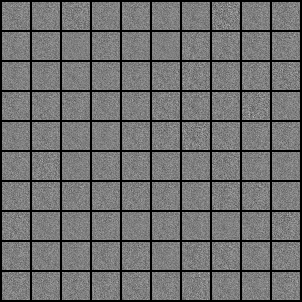

In [71]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

## Step2. Train the GAN model to produce images in this new domain.

In [72]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0701, g_loss: 3.9380, D(x): 0.98, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.0876, g_loss: 5.9704, D(x): 0.96, D(G(z)): 0.03
Epoch [0/300], Step [600/600], d_loss: 0.0488, g_loss: 5.1104, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0240, g_loss: 5.0908, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.0180, g_loss: 5.5435, D(x): 1.00, D(G(z)): 0.01
Epoch [1/300], Step [600/600], d_loss: 0.0112, g_loss: 6.5249, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0274, g_loss: 6.5161, D(x): 0.99, D(G(z)): 0.02
Epoch [2/300], Step [400/600], d_loss: 0.0290, g_loss: 5.1760, D(x): 1.00, D(G(z)): 0.03
Epoch [2/300], Step [600/600], d_loss: 0.0511, g_loss: 5.7877, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.3774, g_loss: 9.0369, D(x): 0.90, D(G(z)): 0.02
Epoch [3/300], Step [400/6

## Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

No difficulty faced here.

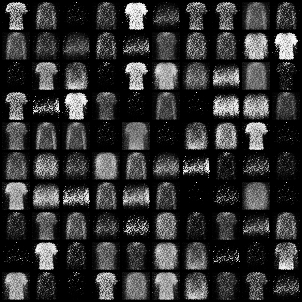

In [73]:
Image('./samples/fake_images-0010.png')

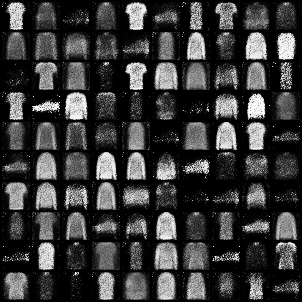

In [74]:
Image('./samples/fake_images-0020.png')

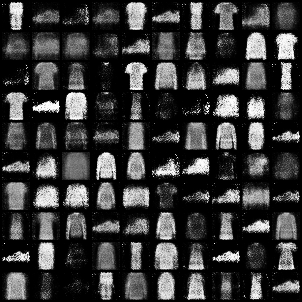

In [75]:
Image('./samples/fake_images-0030.png')

In [ ]:
Image('./samples/fake_images-00102.png')

In [ ]:
Image('./samples/fake_images-00200.png')

In [ ]:
Image('./samples/fake_images-00300.png')

## Step4. Save the model weights in the folder to be used later.

In [76]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [77]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

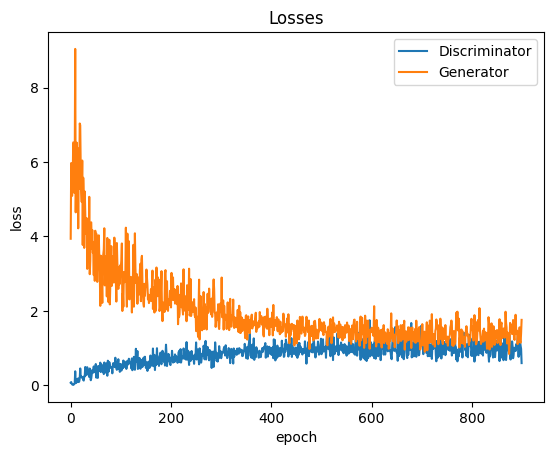

In [78]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

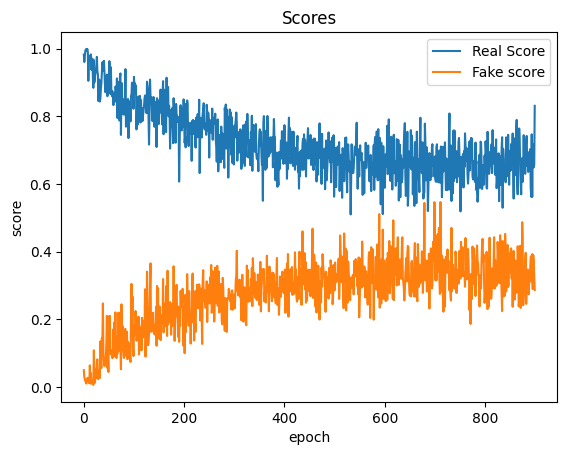

In [79]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

## Step5. Load the model using the saved weights.

In [80]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [81]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [82]:
D.load_state_dict(torch.load('D.ckpt'))
G.load_state_dict(torch.load('G.ckpt'))


<All keys matched successfully>

In [83]:
D.to(device);
G.to(device);

In [ ]:
%%time

num_epochs = 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 0.6752, g_loss: 1.5111, D(x): 0.77, D(G(z)): 0.27
Epoch [0/100], Step [400/600], d_loss: 0.6674, g_loss: 1.5724, D(x): 0.79, D(G(z)): 0.29
Epoch [0/100], Step [600/600], d_loss: 0.6977, g_loss: 1.4748, D(x): 0.76, D(G(z)): 0.27
Saving fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 0.6762, g_loss: 1.6581, D(x): 0.78, D(G(z)): 0.28
Epoch [1/100], Step [400/600], d_loss: 0.7451, g_loss: 1.4397, D(x): 0.79, D(G(z)): 0.32
Epoch [1/100], Step [600/600], d_loss: 0.6996, g_loss: 1.4682, D(x): 0.75, D(G(z)): 0.27
Saving fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 0.7322, g_loss: 1.5594, D(x): 0.78, D(G(z)): 0.31
Epoch [2/100], Step [400/600], d_loss: 0.7546, g_loss: 1.5503, D(x): 0.74, D(G(z)): 0.26
Epoch [2/100], Step [600/600], d_loss: 0.8336, g_loss: 1.5392, D(x): 0.74, D(G(z)): 0.31
Saving fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 0.8134, g_loss: 1.6171, D(x): 0.74, D(G(z)): 0.30
Epoch [3/100], Step [400/6

In [ ]:
Image('./samples/fake_images-0001.png')

In [ ]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

## Step 7: Save the model weights without using checkpoints.

In [ ]:
torch.save(D, 'D_without_checkpoint.model')
torch.save(G, 'G_without_checkpoint.model')


## Step 8: Load the model weights without using checkpoints.

In [ ]:
D = torch.load('D_without_checkpoint.model')
G = torch.load('G_without_checkpoint.model')